# Mounting Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing Required Packages

In [14]:
!pip install transformers==4.27.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install datasets==2.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!pip install tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Libraries

In [17]:
import os
import re
import random
import string
import json
import transformers
from tqdm.auto import tqdm
from datasets import load_dataset, load_metric, ClassLabel, Sequence
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML
from transformers import AutoTokenizer
from transformers import TFAutoModelForQuestionAnswering
from transformers import DefaultDataCollator
from transformers import create_optimizer
import collections
import utils as utils
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import OrderedDict

# Loading and Spliting Dataset

**SQUAD Dataset:** Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.



In [18]:
"""
  Our dataset is the SQuAD dataset as training_set.json, it divided as 80% training and 20% validation set.
"""
# Loading the dataset
dataset_path = '/content/drive/MyDrive/NLP_Project/Dataset/training_set.json'

# the input set we split into training and validation
train_filename = "train_set.json"
val_filename = "val_set.json"

with open(dataset_path) as f:
    dataset_base = json.load(f)

train_split = int(len(dataset_base['data'])*0.80)
train_articles = dataset_base['data'][0:train_split] 
val_articles = dataset_base['data'][train_split:]

In [19]:
# JSON File Writer for Split Dataset
def dataset_import(split_filename, split_articles):
  # Open the file for writing
  with open(split_filename, "w") as f:
    # Iterate over each article in the split dataset
      for article in split_articles:
          title = article["title"]
          # Iterate over each paragraph in the article
          for paragraph in article["paragraphs"]:
              context = paragraph["context"]
              answers = {}      # Create an empty dictionary to store the answers
              # Iterate over each question-answer pair in the paragraph
              for qa in paragraph["qas"]:
                  # Extract the question and ID of the question-answer pair
                  question = qa["question"]
                  idx = qa["id"]
                  # Extract the answer text and answer start position for each answer
                  answers["text"] = [a["text"] for a in qa["answers"]]
                  answers["answer_start"] = [a["answer_start"] for a in qa["answers"]]

                  # Writes a JSON object to the file using json.dump()
                  data = {"id": idx, "title": title, "context": context, "question": question, "answers": answers}
                  json.dump(data, f)
                  f.write("\n")

In [20]:
# imports the train and validation dataset
dataset_import(train_filename, train_articles) #Generating the train json
dataset_import(val_filename, val_articles)  #Generating the validation json
dataset = load_dataset('json', data_files={'train':train_filename, 'validation': val_filename})

# Creating a dictionary containing the data for training
ground_tr_dict = {}
ground_tr_dict['data'] = dataset_base['data'][train_split:]
ground_tr_dict['version'] = dataset_base['version'][train_split:]
# Dumping the ground truth to a JSON file
with open('ground_truth.json', 'w') as json_file:
    json.dump(ground_tr_dict, json_file)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-5f866b8dc9475fab/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Exploratory Data Analysis

In [21]:
# Print the number of documents
print(f"Number of documents: {len(dataset['train'])}")
print(f"Number of documents: {len(dataset['validation'])}")

Number of documents: 69271
Number of documents: 18328


In [22]:
#show first sample of the train dataset
first_sample_train=dataset['train'][0]
first_sample_train

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [23]:
#show first sample of the train dataset
first_sample_validation=dataset['validation'][0]
first_sample_validation

{'id': '572aed7d34ae481900dead27',
 'title': 'Empiricism',
 'context': 'Philosophical empiricists hold no knowledge to be properly inferred or deduced unless it is derived from one\'s sense-based experience. This view is commonly contrasted with rationalism, which states that knowledge may be derived from reason independently of the senses. For example, John Locke held that some knowledge (e.g. knowledge of God\'s existence) could be arrived at through intuition and reasoning alone. Similarly Robert Boyle, a prominent advocate of the experimental method, held that we have innate ideas. The main continental rationalists (Descartes, Spinoza, and Leibniz) were also advocates of the empirical "scientific method".',
 'question': 'What is commonly contrasted with empiricism?',
 'answers': {'text': ['rationalism'], 'answer_start': [173]}}

In [24]:
# calculate the length of each answer in the dataset
def get_answer_length(dataset, data_type):
  """
  Returns a list of lengths for each answer in a dataset.

  Args:
    dataset (dict): A dictionary containing the dataset.
    data_type (str): A string indicating the type of data (e.g., "train", "val", "test").

  Returns:
    list: A list of answer lengths for the specified data type in the dataset.
  """
  answer_lengths = []
  for i in range(0, len(dataset[data_type])):
    for j in range(0, len(dataset[data_type][i]['answers']['text'])):
      # Split the answer text on whitespace and count the resulting tokens
      answer_lengths.append(len(dataset[data_type][i]['answers']['text'][j].split()))
  return answer_lengths

In [25]:
# Compute the distribution of answer lengths in the training set
answer_lengths = get_answer_length(dataset, "train")

# Compute the unique values of answer lengths and their corresponding counts
unique_lengths, counts = np.unique(answer_lengths, return_counts=True)

# Print the distribution of answer lengths
print("Distribution of Answer Lengths in the Training Set:")
for length, count in zip(unique_lengths, counts):
  print(f"Answer Length in words {length}: {count} answers")

Distribution of Answer Lengths in the Training Set:
Answer Length in words 1: 24307 answers
Answer Length in words 2: 17884 answers
Answer Length in words 3: 10478 answers
Answer Length in words 4: 4985 answers
Answer Length in words 5: 3113 answers
Answer Length in words 6: 1941 answers
Answer Length in words 7: 1431 answers
Answer Length in words 8: 1026 answers
Answer Length in words 9: 711 answers
Answer Length in words 10: 582 answers
Answer Length in words 11: 465 answers
Answer Length in words 12: 402 answers
Answer Length in words 13: 324 answers
Answer Length in words 14: 274 answers
Answer Length in words 15: 250 answers
Answer Length in words 16: 165 answers
Answer Length in words 17: 179 answers
Answer Length in words 18: 149 answers
Answer Length in words 19: 112 answers
Answer Length in words 20: 109 answers
Answer Length in words 21: 88 answers
Answer Length in words 22: 90 answers
Answer Length in words 23: 76 answers
Answer Length in words 24: 38 answers
Answer Length 

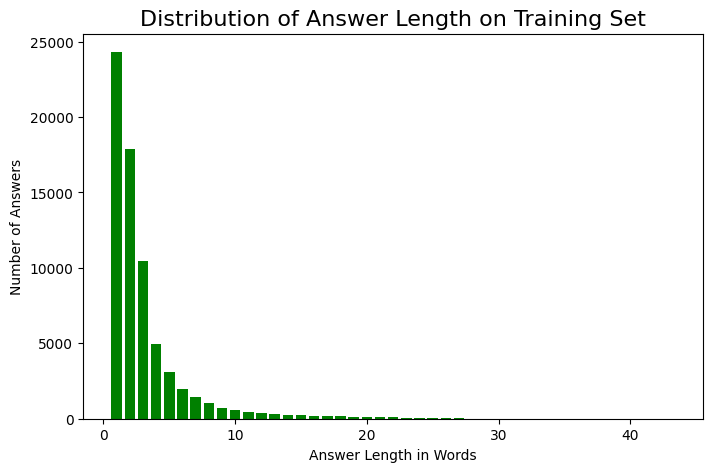

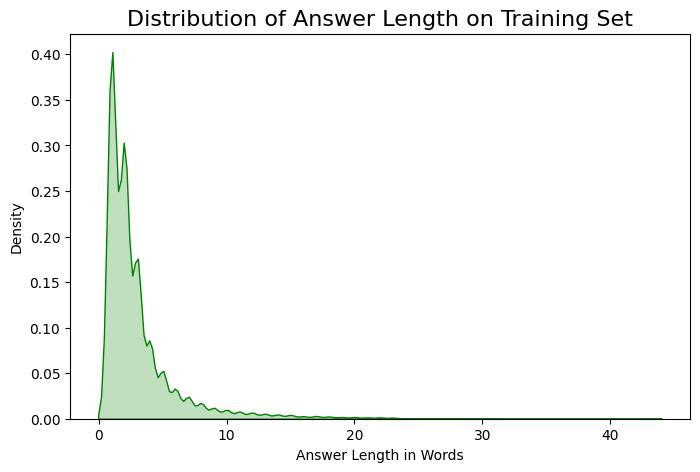

In [26]:
# Plot the distribution of answer lengths of training set
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(unique_lengths, counts, color='green')
ax.set_title('Distribution of Answer Length on Training Set', fontsize=16)
ax.set_ylabel('Number of Answers')
ax.set_xlabel('Answer Length in Words')
plt.show()

# Plot the distribution of answer lengths of training set using a density plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(answer_lengths, fill=True, color='green', ax=ax)
ax.set_title('Distribution of Answer Length on Training Set', fontsize=16)
ax.set_ylabel('Density')
ax.set_xlabel('Answer Length in Words')
plt.show()

In [27]:
# Compute the distribution of answer lengths in the validation set
answer_lengths_val = get_answer_length(dataset, "validation")

# Compute the unique values of answer lengths and their corresponding counts
unique_lengths, counts = np.unique(answer_lengths_val, return_counts=True)

# Print the distribution of answer lengths
print("Distribution of Answer Lengths in the Validation Set:")
for length, count in zip(unique_lengths, counts):
  print(f"Answer Length in words {length}: {count} answers")

Distribution of Answer Lengths in the Validation Set:
Answer Length in words 1: 5960 answers
Answer Length in words 2: 4427 answers
Answer Length in words 3: 2654 answers
Answer Length in words 4: 1408 answers
Answer Length in words 5: 919 answers
Answer Length in words 6: 588 answers
Answer Length in words 7: 417 answers
Answer Length in words 8: 350 answers
Answer Length in words 9: 266 answers
Answer Length in words 10: 201 answers
Answer Length in words 11: 176 answers
Answer Length in words 12: 139 answers
Answer Length in words 13: 116 answers
Answer Length in words 14: 118 answers
Answer Length in words 15: 98 answers
Answer Length in words 16: 81 answers
Answer Length in words 17: 63 answers
Answer Length in words 18: 78 answers
Answer Length in words 19: 50 answers
Answer Length in words 20: 43 answers
Answer Length in words 21: 45 answers
Answer Length in words 22: 31 answers
Answer Length in words 23: 24 answers
Answer Length in words 24: 27 answers
Answer Length in words 25

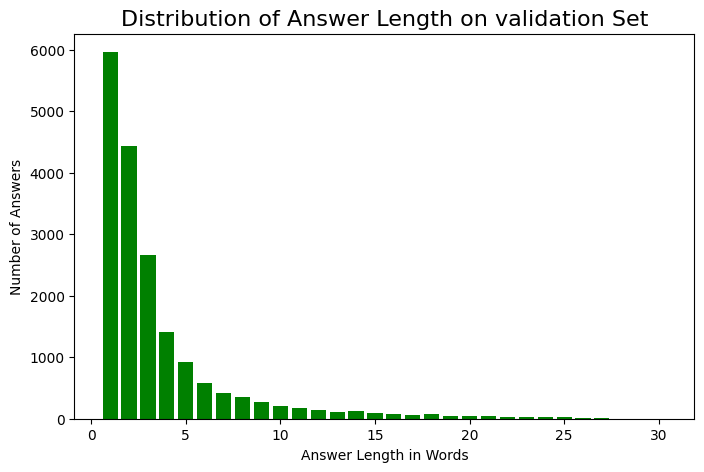

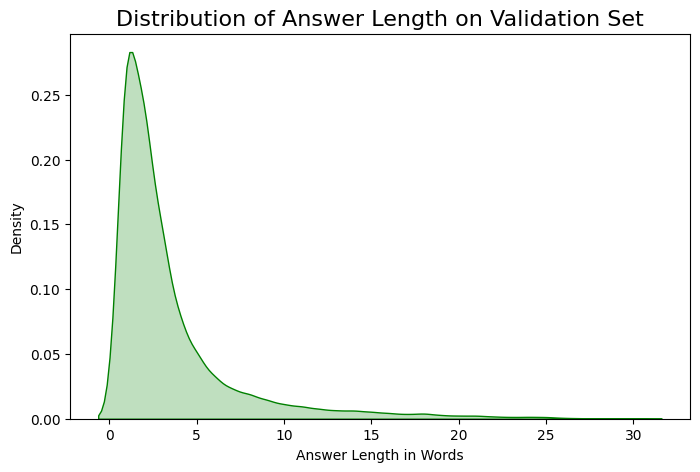

In [28]:
# Plot the distribution of answer lengths of validation set
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(unique_lengths, counts, color='green')
ax.set_title('Distribution of Answer Length on validation Set', fontsize=16)
ax.set_ylabel('Number of Answers')
ax.set_xlabel('Answer Length in Words')
plt.show()

# Plot the distribution of answer lengths of validation set using a density plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(answer_lengths_val, fill=True, color='green', ax=ax)
ax.set_title('Distribution of Answer Length on Validation Set', fontsize=16)
ax.set_ylabel('Density')
ax.set_xlabel('Answer Length in Words')
plt.show()

In [30]:
# calculate the length of features in the dataset
def get_length_distribution(dataset, data_type, feature):
  """
  Returns a list of lengths for a given feature in a dataset.

  Args:
    dataset (dict): A dictionary containing the dataset.
    data_type (str): A string indicating the type of data (e.g., "train", "val", "test").
    feature (str): A string indicating the name of the feature to compute the length distribution for.

  Returns:
    list: A list of lengths for the specified feature in the dataset.
  """
  lengths = []
  for i in range(0, len(dataset[data_type])):
    lengths.append(len(dataset[data_type][i][feature].split()))
  return lengths

In [31]:
# Compute the distribution of question lengths in the training set
question_lengths = get_length_distribution(dataset, "train", "question")

# Compute the unique values of question lengths and their corresponding counts
unique_lengths, counts = np.unique(question_lengths, return_counts=True)

# Print the distribution of question lengths
print("Distribution of Question Lengths in the Training Set:")
for length, count in zip(unique_lengths, counts):
  print(f"Question Length in words {length}: {count} questions")

Distribution of Question Lengths in the Training Set:
Question Length in words 1: 10 questions
Question Length in words 2: 2 questions
Question Length in words 3: 267 questions
Question Length in words 4: 1086 questions
Question Length in words 5: 2980 questions
Question Length in words 6: 5027 questions
Question Length in words 7: 7285 questions
Question Length in words 8: 8642 questions
Question Length in words 9: 8590 questions
Question Length in words 10: 7949 questions
Question Length in words 11: 6715 questions
Question Length in words 12: 5482 questions
Question Length in words 13: 4277 questions
Question Length in words 14: 3227 questions
Question Length in words 15: 2371 questions
Question Length in words 16: 1623 questions
Question Length in words 17: 1141 questions
Question Length in words 18: 830 questions
Question Length in words 19: 565 questions
Question Length in words 20: 390 questions
Question Length in words 21: 270 questions
Question Length in words 22: 148 question

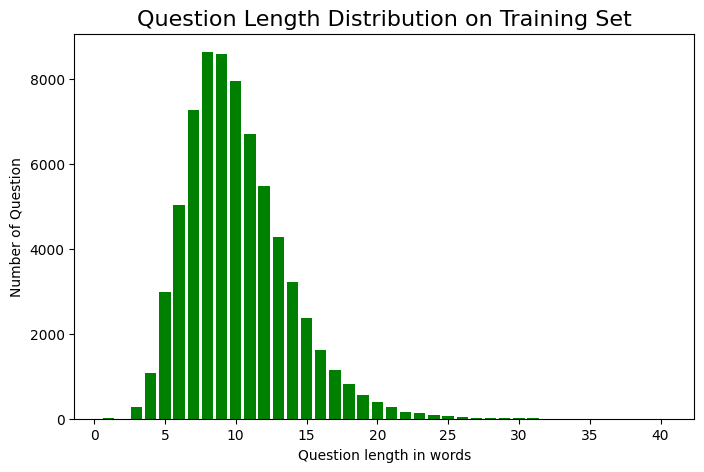

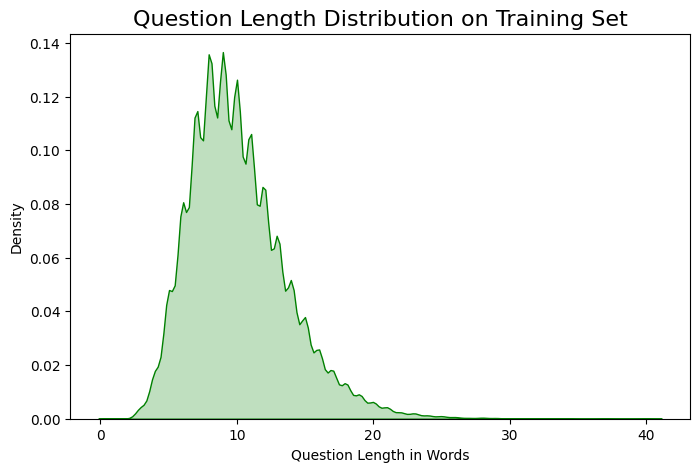

In [32]:
# Plot the distribution of question lengths of training set
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(unique_lengths, counts, color='green')
ax.set_title('Question Length Distribution on Training Set', fontsize=16) 
ax.set_ylabel('Number of Question') 
ax.set_xlabel('Question length in words')
plt.show()

# Plot the distribution of question lengths of training set using a density plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(question_lengths, fill=True, color='green', ax=ax)
ax.set_title('Question Length Distribution on Training Set', fontsize=16)
ax.set_ylabel('Density')
ax.set_xlabel('Question Length in Words')
plt.show()

In [33]:
# Compute the distribution of question lengths in the validation set
question_lengths_val = get_length_distribution(dataset, "validation", "question")

# Compute the unique values of question lengths and their corresponding counts
unique_lengths, counts = np.unique(question_lengths_val, return_counts=True)

# Print the distribution of question lengths
print("Distribution of Question Lengths in the Validation Set:")
for length, count in zip(unique_lengths, counts):
  print(f"Question Length in words {length}: {count} questions")

Distribution of Question Lengths in the Validation Set:
Question Length in words 3: 104 questions
Question Length in words 4: 361 questions
Question Length in words 5: 894 questions
Question Length in words 6: 1410 questions
Question Length in words 7: 1962 questions
Question Length in words 8: 2272 questions
Question Length in words 9: 2424 questions
Question Length in words 10: 2073 questions
Question Length in words 11: 1781 questions
Question Length in words 12: 1471 questions
Question Length in words 13: 1059 questions
Question Length in words 14: 827 questions
Question Length in words 15: 484 questions
Question Length in words 16: 419 questions
Question Length in words 17: 273 questions
Question Length in words 18: 182 questions
Question Length in words 19: 125 questions
Question Length in words 20: 81 questions
Question Length in words 21: 42 questions
Question Length in words 22: 35 questions
Question Length in words 23: 17 questions
Question Length in words 24: 11 questions
Qu

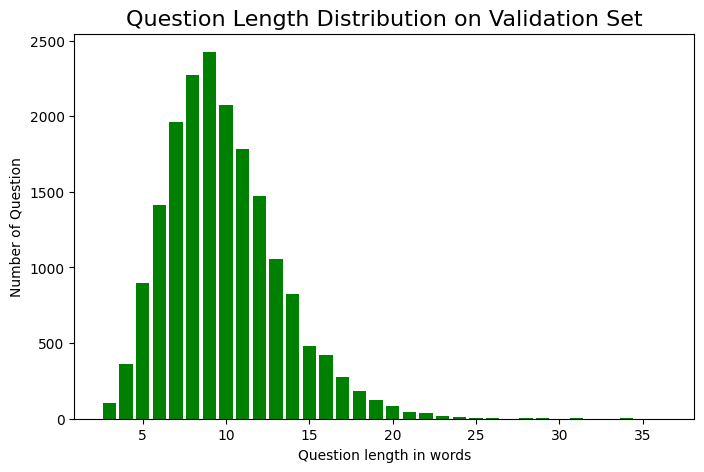

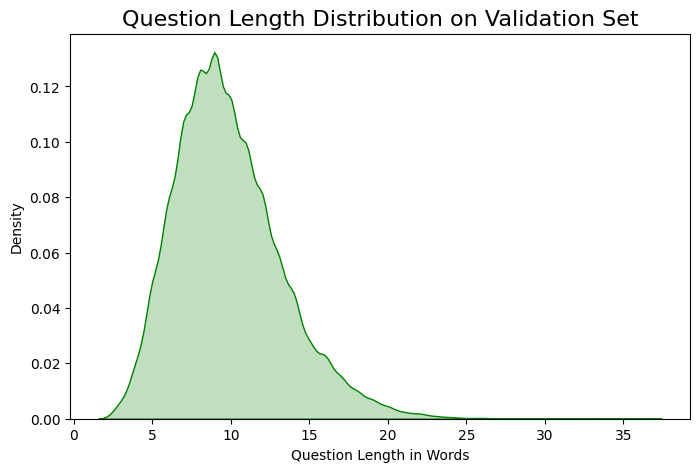

In [34]:
# Plot the distribution of question lengths of validation set
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(unique_lengths, counts, color='green')
ax.set_title('Question Length Distribution on Validation Set', fontsize=16) 
ax.set_ylabel('Number of Question') 
ax.set_xlabel('Question length in words')
plt.show()

# Plot the distribution of question lengths of Validation set using a density plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(question_lengths_val, fill=True, color='green', ax=ax)
ax.set_title('Question Length Distribution on Validation Set', fontsize=16)
ax.set_ylabel('Density')
ax.set_xlabel('Question Length in Words')
plt.show()

# Model-1: ELECTRA model (google/electra-base-generator)

In [35]:
# Set to False if you do not want to train the model
train_model = True
# Assigns the ELECTRA model to the variable "pretrained_model"
pretrained_model =  "google/electra-base-generator"

### Parameters

In [36]:
# Set the batch size for training, due to technical limits we set as 2
batch_size = 2
# Set the learning rate for the optimizer
learning_rate = 2e-5
# Set the number of training epochs
num_train_epochs = 2
# Set the weight decay parameter for regularization
weight_decay = 0.01
# Set the maximum sequence length of question and context features
max_length = 384
# Set the stride for splitting the context into chunks
doc_stride = 128
# Initialize the tokenizer with the chosen pre-trained model
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

### Tokenization

In [37]:
def tokenize_dataset(dataset):
    """   
    Tokenize our questions with truncation and padding, but keep the overflows using a stride.
    This results in one question possible giving several features when a context is long,
    each of those features having a context that overlaps a bit the context of the previous feature.
    """
    tokenized_dataset = tokenizer(dataset["question"], dataset["context"], truncation="only_second", max_length=max_length,
                                  stride=doc_stride, return_overflowing_tokens=True, return_offsets_mapping=True, padding="max_length")

    # Get the mapping from each feature to its corresponding question, which is useful when an example has several features due to long context.
    overflowing_tokens = tokenized_dataset.pop("overflow_to_sample_mapping")

    """ 
    With pop we remove the selected column from the dataset and we store it in sample mapping, 
    basically this is a vector with enumerations from 0 to the lenght of the vector
    created by return_overflowing_tokens in the tokenizer object
    """

     # The offset mappings give a map from token to character position in the original context, making it easier to compute start_positions and end_positions.
    offset_mapping = tokenized_dataset.pop("offset_mapping")

    # Label the questions with start_positions and end_positions
    tokenized_dataset["start_positions"] , tokenized_dataset["end_positions"] = list(),list()
    for i, offsets in enumerate(offset_mapping):
        # Label impossible answers (the answer is in another feature given by an example with a long context) with the index of the CLS token.
        input_ids = tokenized_dataset["input_ids"][i]
        # Get the index of the first token ([CLS]) and the last token ([SEP]) in the sequence, which are used for classification tasks.
        cls_index = input_ids.index(tokenizer.cls_token_id) #usually 0
        # Get the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_dataset.sequence_ids(i)
        # Get the answers for the example that this feature belongs to
        sample_index = overflowing_tokens[i]
        answers = dataset["answers"][sample_index]
        # Get the start and end character index of the answer in the text.
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Get the start token index of the current span in the text.
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1
        # Get the end token index of the current span in the text.

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1
            
        # Check if the answer is out of the span (in which case this feature is labeled with the CLS index).
        if(offsets[token_start_index][0] > start_char
                or offsets[token_end_index][1] < end_char):
          
            tokenized_dataset["start_positions"].append(cls_index)
            tokenized_dataset["end_positions"].append(cls_index)
        else:
            # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
            # Note: we could go after the last offset if we are in the edge case such that the answer is the last word.
            while (
                token_start_index < len(offsets)
                and offsets[token_start_index][0] <= start_char
            ):
              token_start_index += 1
            tokenized_dataset["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_dataset["end_positions"].append(token_end_index + 1)

    return tokenized_dataset

tokenized_datasets = dataset.map(tokenize_dataset, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/69271 [00:00<?, ? examples/s]

Map:   0%|          | 0/18328 [00:00<?, ? examples/s]

In [40]:
# Create a data collator that will be used to combine the input data into batches
data_collator = DefaultDataCollator(return_tensors="tf")
# Convert the tokenized train dataset to a TensorFlow dataset, selecting only the necessary columns
train_set = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,)
# Convert the tokenized validation dataset to a TensorFlow dataset, selecting only the necessary columns
validation_set = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,)

In [41]:
# Calculate total training steps based on batch size and number of epochs
total_train_steps = (len(tokenized_datasets["train"]) // batch_size) * num_train_epochs
# Create optimizer and scheduler
optimizer, schedule = create_optimizer(init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps)

### Model Loading

In [42]:
# Load pre-trained model for fine-tuning
model = TFAutoModelForQuestionAnswering.from_pretrained(pretrained_model)
# Compile the model with optimizer and loss function
model.compile(optimizer=optimizer)
model.summary()

Some layers from the model checkpoint at google/electra-base-generator were not used when initializing TFElectraForQuestionAnswering: ['activation', 'generator_predictions', 'generator_lm_head']
- This IS expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-generator and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - t

Model: "tf_electra_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 electra (TFElectraMainLayer  multiple                 33511168  
 )                                                               
                                                                 
 qa_outputs (Dense)          multiple                  514       
                                                                 
Total params: 33,511,682
Trainable params: 33,511,682
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Define the base path and directory to save fine-tuned model
base_path = '/content/'
path = os.path.join(base_path, 'fine_tuned_' + pretrained_model+  '/')

# If training flag is set to True, train the model and save the fine-tuned model
if train_model == True:
    history = model.fit(train_set, epochs=num_train_epochs, validation_data=validation_set)
    model.save_pretrained(path)
else:
    model.load_weights(os.path.join(path, 'tf_model.h5'))

Epoch 1/2
35003/35003 [==============================] - 4150s 117ms/step - loss: 1.6860 - val_loss: 1.3613
Epoch 2/2
35003/35003 [==============================] - 3978s 114ms/step - loss: 1.0697 - val_loss: 1.2938


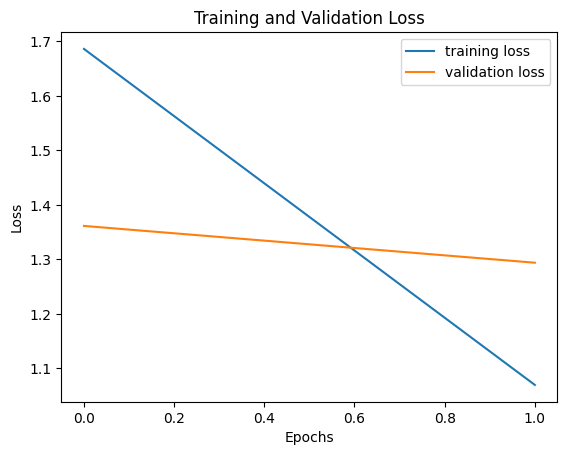

In [44]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
def process_test_data(dataset):
  """
   Tokenize the question and context using tokenizer with truncation and padding. 
    The overflows are kept using a stride in case the context is too long.
    This may result in one question giving multiple features when a context is long.
    Each feature has a context that overlaps with the previous feature.
  """
  tokenized_dataset = tokenizer(dataset["question"], dataset["context"], truncation="only_second", max_length=max_length,
                                stride=doc_stride, return_overflowing_tokens=True, return_offsets_mapping=True, padding="max_length")

  # Get a mapping from a feature to its corresponding example since one example might give several features
  # if it has a long context.
  overflowing_tokens = tokenized_dataset.pop("overflow_to_sample_mapping")

  # Store the example_id that gave us this feature and the offset mappings
  tokenized_dataset["example_id"] = []

  for i in range(len(tokenized_dataset["input_ids"])):
      # Get the sequence corresponding to the example to determine what is the context and what is the question
      sequence_ids = tokenized_dataset.sequence_ids(i)
      context_index = 1

      # Get the index of the example containing this span of text, since one example can give several spans of text.
      token_index = overflowing_tokens[i]
      tokenized_dataset["example_id"].append(dataset["id"][token_index])

      # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
      # position is part of the context or not.
      tokenized_dataset["offset_mapping"][i] = [
          (o if sequence_ids[k] == context_index else None)
          for k, o in enumerate(tokenized_dataset["offset_mapping"][i])]

  return tokenized_dataset

### Prepare Test Dataset

In [46]:
# Map the test data to the function 'process_test_data' for processing the data in batches
test_features = dataset["validation"].map(
    process_test_data,
    batched=True,
    remove_columns=dataset["validation"].column_names)
# Convert the test features to a TensorFlow dataset with the required columns
test_dataset = test_features.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator)
# Get the raw predictions from the model on the test dataset
raw_predictions = model.predict(test_dataset)

Map:   0%|          | 0/18328 [00:00<?, ? examples/s]

9260/9260 [==============================] - 992s 107ms/step


# Model Evaluation

In [47]:
def postprocess_qn_anw_predictions(examples, features, all_start_logits, all_end_logits, n_best_size=20, max_answer_length=30): 
      """
      Postprocesses the raw model predictions for question answering tasks.

      Args:
          examples: A list of examples, where each example is a dictionary containing an "id" field
              and a "context" field.
          features: A list of dictionaries, where each dictionary represents the features for a single
              example. Each dictionary should contain an "example_id" field, an "input_ids" field, and an
              "offset_mapping" field.
          all_start_logits: A list of lists, where each sublist contains the start logits for one example.
          all_end_logits: A list of lists, where each sublist contains the end logits for one example.
          n_best_size: The number of top-scoring predictions to consider when predicting the answer span.
          max_answer_length: The maximum length (in characters) allowed for the predicted answer span.

      Returns:
          predictions: A dictionary mapping example IDs to predicted answer spans.
      """
    
      # Build a map from example ID to its corresponding index in the examples list.
      example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
      # Create a dictionary that maps each example index to a list of feature indices for that example.
      features_per_example = collections.defaultdict(list) 
      for i, feature in enumerate(features): 
          features_per_example[example_id_to_index[feature["example_id"]]].append(i) 

      # Create an ordered dictionary to store the predictions.
      predictions = collections.OrderedDict() 
      # Print information about the number of examples and features being processed.
      print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

      # Loop through all examples.
      for example_index, example in enumerate(tqdm(examples)): 
          # Get the list of feature indices corresponding to this example.
          feature_indices = features_per_example[example_index]
          # Create an empty list to store valid answers.
          valid_answers = []
          # Get the context for this example.
          context = example["context"]
          # Loop through all features corresponding to this example.
          for feature_index in feature_indices: 
              # Get the start and end logits for this feature.
              start_logits = all_start_logits[feature_index]
              end_logits = all_end_logits[feature_index]

              # Get the offset mapping for this feature.
              offset_mapping = features[feature_index]["offset_mapping"]

              # Compute the score for predicting a null answer for this feature.
              cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
              feature_null_score = start_logits[cls_index] + end_logits[cls_index]
              min_null_score = feature_null_score 

              # Loop through all possible combinations of start and end indices.
              start_indexes = np.argsort(start_logits)[ -1 : -n_best_size - 1 : -1 ].tolist() 
              end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist() 

              for start_index in start_indexes: 
                  for end_index in end_indexes: 
                        # Skip invalid combinations of start and end indices.
                      if (start_index >= len(offset_mapping) or end_index >= len(offset_mapping) or
                              offset_mapping[start_index] is None or offset_mapping[end_index] is None or
                              end_index < start_index or end_index - start_index + 1 > max_answer_length):
                          continue
                      # Don't consider answers with a length that is either < 0 or > max_answer_length. 
                      if (end_index < start_index or end_index - start_index + 1 > max_answer_length):
                          continue 
                      try:   
                          start_char = offset_mapping[start_index][0] 
                          end_char = offset_mapping[end_index][1] 
                          valid_answers.append( 
                              { 
                                  "score": start_logits[start_index] + end_logits[end_index], 
                                  "text": context[start_char:end_char], 
                              } 
                          ) 

                      except IndexError: 
                          start_char = 0
                          end_char = 0 
                          valid_answers.append( 
                              { 
                                  "score": 0, 
                                  "text": context[start_char:end_char], 
                              } 
                          ) 

          if len(valid_answers) > 0: 
              best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0] 
          else: 
              # If there are no valid answers, create a fake prediction to avoid failure.
              best_answer = {"text": "", "score": 0.0}
          # Store the best answer for the current example in the predictions dictionary.
          predictions[example["id"]] = best_answer["text"] 

      return predictions
final_predictions = postprocess_qn_anw_predictions(dataset["validation"], test_features, raw_predictions["start_logits"], raw_predictions["end_logits"])

Post-processing 18328 example predictions split into 18519 features.


  0%|          | 0/18328 [00:00<?, ?it/s]

In [48]:
# evaluation of the model
with open('predictions.json', 'w') as json_file:
    json.dump(final_predictions, json_file)
!python3 evaluate.py ground_truth.json predictions.json 

{
  "exact": 57.69314709733741,
  "f1": 73.68111766448331,
  "total": 18328,
  "HasAns_exact": 57.69314709733741,
  "HasAns_f1": 73.68111766448331,
  "HasAns_total": 18328
}


### Evaluation of Results - Error Analysis

In [49]:
# Compute evaluation metrics for a question answering task
# Exact match (EM) and F1 score are used as performance metrics

# Compute raw scores using ground truth dictionary and final predictions
exact_raw, f1_raw = utils.get_raw_scores(ground_tr_dict, final_predictions) 
# Compute ordered F1 scores based on answer length
f1_len = utils.computes_f1(ground_tr_dict, f1_raw) 

In [50]:
# Compute the average F1 score for each answer length
answer_length_scores, average_scores = utils.compute_avg_f1(f1_len)

# Find the worst-performing answer length based on F1 score
worst_answer_length = min(zip(answer_length_scores, average_scores), key=lambda x: x[1])[0]

# Extract a subset of the data where the answer length is worst_answer_length
worst_length_data = utils.get_data_from_len(ground_tr_dict, final_predictions, worst_answer_length)

# Loop through the subset of data and print out the context, question, ground truth answer, and predicted answer for each example
for i in range(len(worst_length_data)):
    print('Context: ', worst_length_data[i]['context'])
    print('Question: ', worst_length_data[i]['question'])
    print('Answer: ', worst_length_data[i]['answer'])
    print('Predicted Answer: ', worst_length_data[i]['answer_pred'])
    print()

Context:  Post-punk was an eclectic genre which resulted in a wide variety of musical innovations and helped merge white and black musical styles. Out of the post-punk milieu came the beginnings of various subsequent genres, including new wave, dance-rock, New Pop, industrial music, synthpop, post-hardcore, neo-psychedelia alternative rock and house music. Bands such as Joy Division, Siouxsie and the Banshees, Bauhaus and the Cure played in a darker, more morose style of post-punk that lead to the development of the gothic rock genre.
Question:  What styles of music did post-punk pave the way for?
Answer:  new wave, dance-rock, New Pop, industrial music, synthpop, post-hardcore, neo-psychedelia alternative rock and house music
Predicted Answer:  white and black

Context:  Calvin Veltman undertook, for the National Center for Education Statistics and for the Hispanic Policy Development Project, the most complete study of English language adoption by Hispanophone immigrants. Mr Veltman's

### F1-Graphs

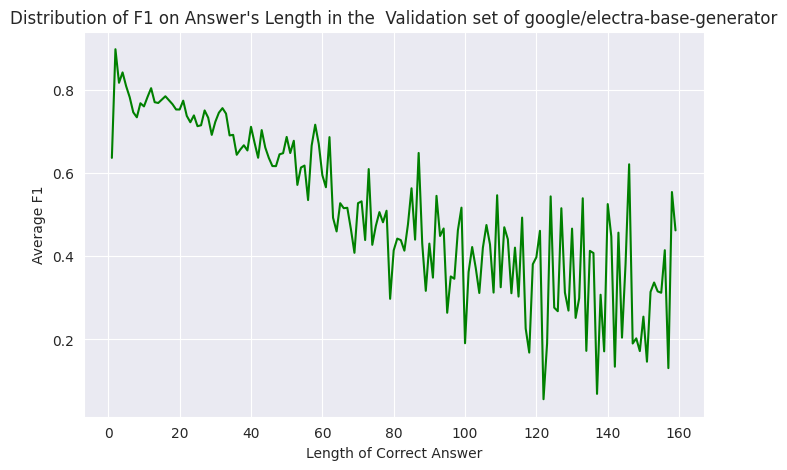

In [51]:
def f1_graphic(f1_len, xlabel,ylabel,title, name_png, pretrained_model):
  x, y = x, y = utils.compute_avg_f1(f1_len)
  sns.set_style('darkgrid')
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.plot(x, y, color='green')
  ax.set(xlabel=xlabel, ylabel=ylabel, title=title+pretrained_model)
  fig.savefig(name_png)
  plt.show()

# compute the F1 score
f1_scores = utils.computes_f1(ground_tr_dict, f1_raw)

# plot the distribution of F1 scores based on answer lengths
f1_graphic(f1_scores, "Length of Correct Answer", "Average F1",
                 "Distribution of F1 on Answer's Length in the  Validation set of ",
                 "Distribution_of_F1_Answers.png", pretrained_model)

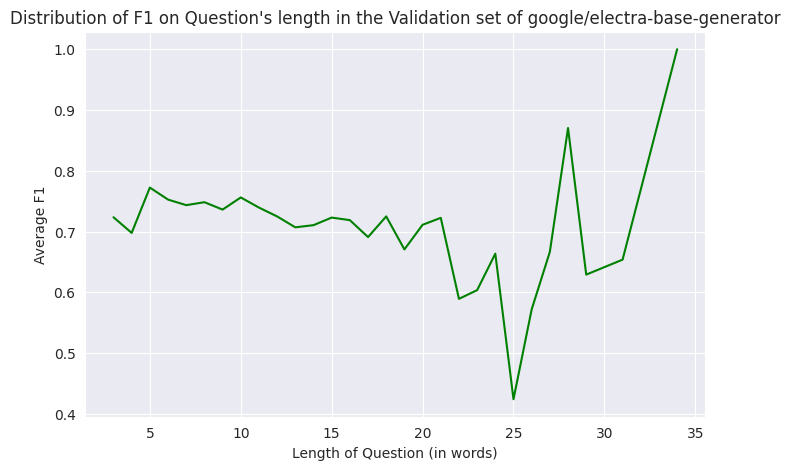

In [52]:
# Compute F1 scores for each question length
f1_scores = utils.computes_f1_q(ground_tr_dict, f1_raw)
# plot the distribution of F1 scores based on question lengths
f1_graphic(f1_scores, "Length of Question (in words)", "Average F1",
                 "Distribution of F1 on Question's length in the Validation set of ",
                 "Distribution_of_F1_Question.png", pretrained_model)